In [1]:
import torch
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import yaml
import argparse
import copy
from diffusion_model import Model 
import torchvision.utils as tvu
import shutil
import glob
import time
import torch.utils.data as data 
import torch.optim as optim

In [2]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [3]:
class EMAHelper(object):
    """read about EMA
    exponential moving average (EMA) of model weights
    """
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module,torch.nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(
                inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy =torch.nn.DataParallel(module_copy, inner_module.args.dataparallel)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

def get_optimizer(config, parameters):
    if config.optim.optimizer == 'Adam':
        return optim.Adam(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay,
                          betas=(config.optim.beta1, 0.999), amsgrad=config.optim.amsgrad,
                          eps=config.optim.eps)
    elif config.optim.optimizer == 'RMSProp':
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == 'SGD':
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError(
            'Optimizer {} not understood.'.format(config.optim.optimizer))
    
def noise_estimation_loss(net, images, labels=None, augment_pipe=None):
    rnd_normal = torch.randn([images.shape[0],], device=images.device)
    P_mean = np.log(args.sigma_start*args.sigma_end)/2
    P_std = np.log(args.sigma_start/args.sigma_end)/2
    sigma = (rnd_normal * P_std + P_mean).exp()
    reshaped_sigma = sigma.reshape(images.shape[0], 1, 1, 1)
    y = images
    n = torch.randn_like(y) * reshaped_sigma
    D_yn = net(y + n, sigma)
    loss = ((D_yn - y) ** 2)
    return loss.mean()

In [4]:
class Diffusion(object):
    def __init__(self, args, config, device=None
                ):
        self.args = args
        self.config = config
        self.sigma_min = args.sigma_end **2 /args.sigma_start
        self.sigma_max = args.sigma_start **2 /args.sigma_end
        self.rho = args.rho
        self.loss_his = []
        self.val_loss_his = []
        self.val_loss_steps = []
        self.P_mean = np.log(args.sigma_start*args.sigma_end)/2
        self.P_std = np.log(args.sigma_start/args.sigma_end)/2
        
        if device is None:
            device = (
                self.config.device
                if torch.cuda.is_available()
                else torch.device("cpu")
            )
        self.device = device
        self.num_timesteps = config.diffusion.num_diffusion_timesteps
            
    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)
    
    def train(self):
        args, config = self.args, self.config
        tb_logger = self.config.tb_logger
        dataset = train_images_tensor
        val_dataset = val_images_tensor[:config.training.batch_size]
#         val_dataset = val_images_tensor
        train_loader = data.DataLoader(
            dataset,
            batch_size=config.training.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
        )
        model = Model(config)

        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Number of parameters in the model: {total_params}")
        
        model = model.to(self.device)
        model = torch.nn.DataParallel(model,self.args.dataparallel)

        optimizer = get_optimizer(self.config, model.parameters())

        if self.config.model.ema:
            ema_helper = EMAHelper(mu=self.config.model.ema_rate)
            ema_helper.register(model)
        else:
            ema_helper = None

        start_epoch, step = 0, 0
        if self.args.resume_training:
            states = torch.load(os.path.join(self.args.log_path, "ckpt.pth"))
            model.load_state_dict(states[0])

            states[1]["param_groups"][0]["eps"] = self.config.optim.eps
            states[1]["param_groups"][0]["lr"] = self.config.optim.lr
            optimizer.load_state_dict(states[1])
            start_epoch = states[2]
            step = states[3]
            if self.config.model.ema:
                ema_helper.load_state_dict(states[4])

        for epoch in range(start_epoch, self.config.training.n_epochs):
            data_start = time.time()
            data_time = 0
            for i, x in enumerate(train_loader):
                data_time += time.time() - data_start
                model.train()
                step += 1
                x = x.to(self.device)
                loss_registry = {'simple': noise_estimation_loss,}

                loss = loss_registry[config.model.type](net = model, images = x)

                print(
                    f"step: {step}, loss: {loss.item()}, data time: {data_time / (i+1)}"
                )

                optimizer.zero_grad()
                loss.backward()

                try:
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.optim.grad_clip
                    )
                except Exception:
                    pass
                
                optimizer.step()

                if self.config.model.ema:
                    ema_helper.update(model)

                if step % self.config.training.snapshot_freq == 0 or step == 1:
                    states = [
                        model.state_dict(),
                        optimizer.state_dict(),
                        epoch,
                        step,
                    ]
                    if self.config.model.ema:
                        states.append(ema_helper.state_dict())

                    torch.save(
                        states,
                        os.path.join(self.args.log_path, "ckpt_{}.pth".format(step)),
                    )
                    torch.save(states, os.path.join(self.args.log_path, "ckpt.pth"))
                
                if step % self.config.training.validation_freq == 0 :   
                    model.eval()
                    self.sample_sequence(model, training = True, step = step)
                
                data_start = time.time()
            
            val_dataset = val_dataset.to(self.device)
            val_loss = loss_registry[config.model.type](net = model, images = val_dataset)
            self.val_loss_his = np.append(self.val_loss_his, val_loss.item())
            self.val_loss_steps = np.append(self.val_loss_steps, epoch)
            
            self.loss_his = np.append(self.loss_his,loss.item())
            his_len = [ _ for _ in range(0, len(self.loss_his))]
            plt.figure()
            plt.plot(his_len, self.loss_his, label = "loss")
            plt.plot(self.val_loss_steps, self.val_loss_his, label = "val_loss")
            plt.legend()
            plt.savefig(os.path.join(self.args.log_path, 'loss_his.png'))
            np.save(os.path.join(self.args.log_path, "loss_his.npy"), self.loss_his)

    def sample(self):
        model = Model(self.config)
        if self.args.ckpt_id is None:
            states = torch.load(
                os.path.join(self.args.log_path, "ckpt.pth"),
                map_location=self.config.device,
            )
        else:
            states = torch.load(
                os.path.join(
                    self.args.log_path, f"ckpt_{self.args.ckpt_id}.pth"
                ),
                map_location=self.config.device,
            )
            print('load ckpt: ', self.args.ckpt_id)
            
        model = model.to(self.device)
        model = torch.nn.DataParallel(model, self.args.dataparallel)
#         model = model.to(self.device)
        model.load_state_dict(states[0], strict=True)
        print('load epoch: ', states[3])

        model.eval()

        if self.args.fid:
            self.sample_fid(model)
        elif self.args.interpolation:
            self.sample_interpolation(model)
        elif self.args.sequence:
            self.sample_sequence(model)
        else:
            raise NotImplementedError("Sample procedeure not defined")

    def sample_fid(self, model):
        config = self.config
        img_id = len(glob.glob(f"{self.args.image_folder}/*"))
        print(f"starting from image {img_id}")
        total_n_samples = 300
        n_rounds = (total_n_samples - img_id) // config.sampling.batch_size

        with torch.no_grad():
            for _ in tqdm.tqdm(
                range(n_rounds), desc="Generating image samples for FID evaluation."
            ):
                n = config.sampling.batch_size
                x = torch.randn(
                    n,
                    config.data.channels,
                    config.data.image_size,
                    config.data.image_size,
                    device=self.device,
                )

                x = self.sample_image(x, model)
#                 x = inverse_data_transform(config, x)
                x = [(y + 1.0) / 2.0 for y in x]
                for i in range(n):
                    tvu.save_image(
                        x[i], os.path.join(self.args.image_folder, f"{img_id}.png")
                    )
                    img_id += 1

    def sample_sequence(self, model, training = False, step = None):
        config = self.config

        x = torch.randn(
            config.sampling.batch_size,
            config.data.channels,
            config.data.image_size,
            config.data.image_size,
            device=self.device,
        )
        
        data_start = time.time()
        data_time = 0
        # NOTE: This means that we are producing each predicted x0, not x_{t-1} at timestep t.
        with torch.no_grad():
            x = self.sample_image(x, model)
        data_time += time.time() - data_start
        print(f"the sample time of {self.config.sampling.batch_size} images takes {data_time}")

#         x = [inverse_data_transform(config, y) for y in x]
        x = [(y + 1.0) / 2.0 for y in x]
#         if not training:
#             for i in range(len(x)):
#                 for j in range(x[i].size(0)):
#                     tvu.save_image(
#                         x[i][j], os.path.join(self.args.image_folder, f"{step}_{j}_{i}.png")
#                     )
        for i in range(20):
            tvu.save_image(x[i], os.path.join(self.args.image_folder, f"generated_{i}.png"))
        if not training:
            plt.figure(figsize=(40, 8))
            
            for i in range(20):
                plt.ioff()
                plt.subplot(2, 10, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                plt.imshow(np.asarray(img), cmap='gray')
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"generated_image_{self.args.sample_type}_{self.args.skip_type}_{self.args.timesteps}_{data_time}s.png"))  
        
        else:
            plt.figure(figsize=(16, 8))
            
            for i in range(8):
                plt.ioff()
                plt.subplot(2, 4, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                plt.imshow(np.asarray(img), cmap='gray')
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"{step}.png"))
            
#             tvu.save_image(
#                         x[999,:,:,:,:], os.path.join(self.args.image_folder, f"{step}.png")
#                     )

    def sample_interpolation(self, model):
        config = self.config

        test_dataset = test_images_tensor 
        test_dataset = test_dataset.to(self.device)
        
        def slerp(z1, z2, alpha):
            theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
            return (
                torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
                + torch.sin(alpha * theta) / torch.sin(theta) * z2
            )
        x1 = test_dataset[:1]
        x2 = test_dataset[7:8]

        tvu.save_image(x1, os.path.join(self.args.generated_image_folder, f"source_1.png"))
        tvu.save_image(x2, os.path.join(self.args.generated_image_folder, f"source_2.png"))
        
         # Time step discretization.
        step_indices = torch.arange(self.args.timesteps, device=self.device)
        t_steps = (self.sigma_max ** (1 / self.rho) + step_indices / (self.args.timesteps - 1) * (self.sigma_min ** (1 / self.rho) - self.sigma_max ** (1 / self.rho))) ** self.rho
        t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
        t_steps = t_steps.flip(0)
        
        z1 = x1
        z2 = x2
        
        for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
            z1 = z1 + (t_next-t_cur) * torch.randn_like(z1)
            z2 = z2 + (t_next-t_cur) * torch.randn_like(z2)
        
        z1 = z1/80
        z2 = z2/80
        
        alpha = torch.arange(0.0, 1.01, 0.1).to(z1.device)
        z_ = []
        for i in range(alpha.size(0)):
            z_.append(slerp(z1, z2, alpha[i]))

        x = torch.cat(z_, dim=0)
        xs = []

        # Hard coded here, modify to your preferences
        with torch.no_grad():
            for i in range(0, x.size(0), 8):
                xs.append(self.sample_image(x[i : i + 8], model))
#         x = inverse_data_transform(config, torch.cat(xs, dim=0))
        x = [(y + 1.0) / 2.0 for y in torch.cat(xs, dim=0)]
        for i in range(len(x)):
            tvu.save_image(x[i], os.path.join(self.args.generated_image_folder, f"{i}.png"))

    def sample_image(self, x, model):
        
        
        data_start = time.time()
        data_time = 0
        if self.args.sample_type == "deterministic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max = self.sigma_max, rho = self.rho)
        elif self.args.sample_type == "stochastic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max = self.sigma_max, rho = self.rho, S_churn=40, S_min= self.sigma_min/2*5, S_max=self.sigma_max/8*5, S_noise=1.003)
        else:
            raise NotImplementedError
        return x
        data_time += time.time() - data_start
        print(data_time)
        
    def test(self):
        pass


In [5]:
def edm_sampler(
    latents, num_steps, net,  class_labels=None, randn_like=torch.randn_like, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1
):
    
    # Time step discretization.
    step_indices = torch.arange(num_steps, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = [latents * t_steps[0]]
#     x_next = [latents]
    print(t_steps)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        
        t_cur = torch.ones(x_next[0].shape[0], device=t_cur.device) * t_cur
        t_next = torch.ones(x_next[0].shape[0], device=t_next.device) * t_next
        
        x_cur = x_next[-1]

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur[0] <= S_max else 0
        t_hat = torch.as_tensor(t_cur + gamma * t_cur)
        x_hat = (x_cur + (t_hat[0] ** 2 - t_cur[0] ** 2).sqrt() * S_noise * randn_like(x_cur))
        
        # Euler step.
#         denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        denoised = net(x_hat, t_hat)
        d_cur = (x_hat - denoised) / t_hat[0]
        x_next_ = x_hat + (t_next[0] - t_hat[0]) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next_, t_next)
#             denoised = net(x_next_, t_next, class_labels)
            d_prime = (x_next_ - denoised) / t_next[0]
            x_next_ = x_hat + (t_next[0] - t_hat[0]) * (0.5 * d_cur + 0.5 * d_prime)
        
        x_next.append(x_next_)
        
#         for i, _x_next in enumerate(x_next):
#             tvu.save_image(_x_next, os.path.join("18steps_generation_process", f"generated_step_{i}.png"))
        
    return x_next[-1].cpu()

In [6]:
torch.set_printoptions(sci_mode=False)
args = {
    'config': 'biked_256.yml',
    'seed': 1234,
    'exp': 'result_diffusion_model',
    'doc': 'log_folder',
    'comment': "",
    'verbose': "info",
    'sequence': False,
    'test': False,
    'sample': False,
    'fid': False,
    'interpolation': False,
    'resume_training': False,
    'image_folder': "result_diffusion_model/images",
    'generated_image_folder': "SDM_iterative_noise_best",
    'ni': False,
    'use_pretrained': False,
    'sample_type': "stochastic",
#     deterministic, stochastic
    'timesteps': 18,
    'eta': 0.0,
    'dataparallel': [0,1,2,3],
#     'ckpt_id': '108000',
    'rho' : 7,
#     'skip': 500,
    'sigma_start' : 14.4,
    'sigma_end' : 1.64,
}

args['log_path']=os.path.join(args['exp'], "logs", args['doc'])
args = dict2namespace(args)
with open(args.config, "r") as f:
    config = yaml.safe_load(f)
config['tb_logger'] = None
config = dict2namespace(config)
tb_path = os.path.join(args.exp, "tensorboard", args.doc)

(3412, 256, 256, 1)
train image data range: { -1.0 ~ 1.0 }
(100, 256, 256, 1)
train image data range: { -1.0 ~ 1.0 }


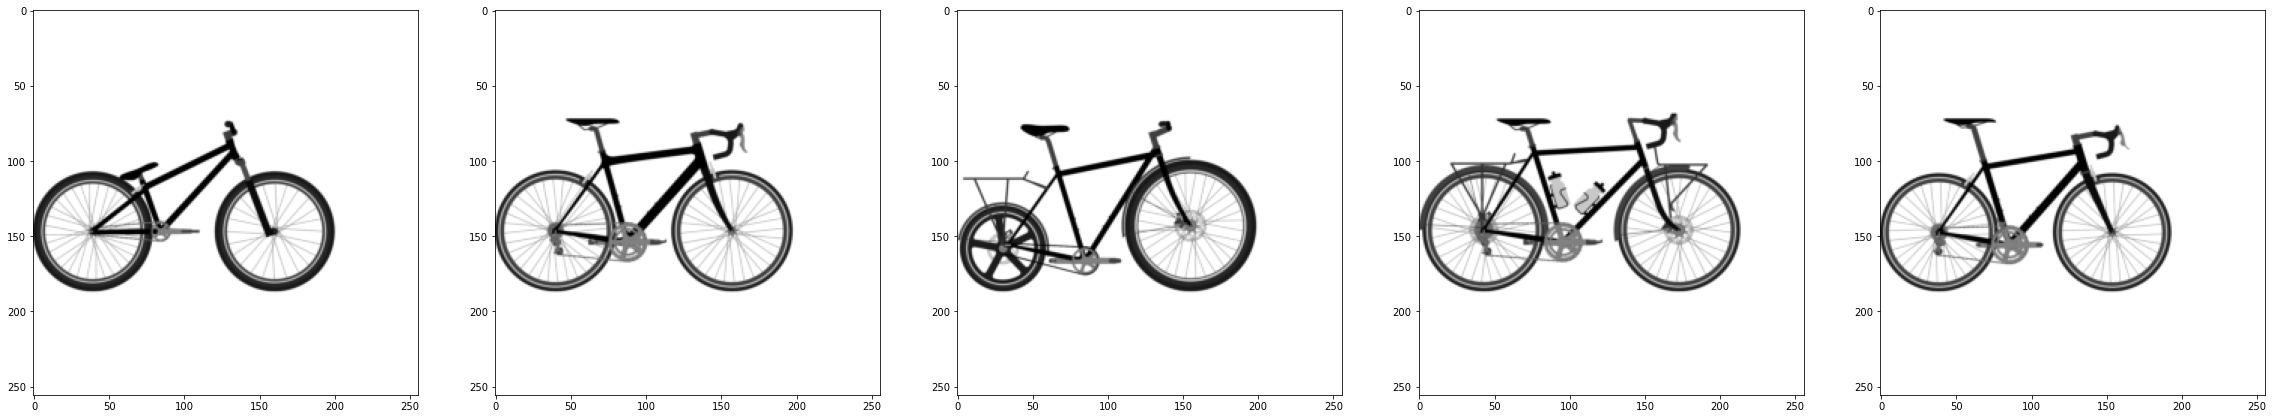

In [7]:
if not args.test and not args.sample:
    train_images = np.load('/home/q603750/q603750/00_Datasets/BIKED/biked_train_256.npy', mmap_mode='r')
    val_images = np.load('/home/q603750/q603750/00_Datasets/BIKED/biked_val_256.npy', mmap_mode='r')
    train_images = train_images/0.5-1
    val_images = val_images/0.5-1
    print(train_images.shape)
    print("train image data range: {", train_images[:100].min(),"~",train_images[:100].max(),"}")
    print(val_images.shape)
    print("train image data range: {", val_images.min(),"~",val_images.max(),"}")
    train_images_tensor = torch.tensor(train_images)
    train_images_tensor = train_images_tensor.permute((0, 3, 1, 2))
    val_images_tensor = torch.tensor(val_images)
    val_images_tensor = val_images_tensor.permute((0,3, 1, 2))
    plotting_images = train_images
    del train_images

else:
    test_images = np.load('/home/q603750/q603750/00_Datasets/BIKED Dataset/biked_test_256.npy', mmap_mode='r')
    test_images = test_images/0.5-1
    test_images_tensor = torch.tensor(test_images)
    test_images_tensor = test_images_tensor.permute((0,3, 1, 2))
    plotting_images = test_images
    del test_images

plt.figure(figsize=(40, 200))
plt.subplot(1, 5, 1)
plt.imshow(plotting_images[0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(plotting_images[5, :, :, 0], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(plotting_images[6, :, :, 0], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(plotting_images[7, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(plotting_images[8, :, :, 0], cmap='gray')

In [8]:
torch_device = "cuda:" + str(args.dataparallel[0])
device = torch.device(torch_device) if torch.cuda.is_available() else torch.device("cpu")
print("Using device: {}".format(device))
config.device = device

# set random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

torch.backends.cudnn.benchmark = True

if not args.test and not args.sample:
    if not args.resume_training:
        if os.path.exists(args.log_path):
            overwrite = False
            if args.ni:
                overwrite = True
            if overwrite:
                shutil.rmtree(args.log_path)
                os.makedirs(args.log_path)
                if os.path.exists(tb_path):
                    shutil.rmtree(tb_path)
            else:
                print("Folder exists. Program halted.")
        else:
            os.makedirs(args.log_path)
        
        if os.path.exists(args.image_folder):
            if args.ni:
                overwrite = True
            if overwrite:
                shutil.rmtree(args.image_folder)
                os.makedirs(args.image_folder)
            else:
                print("Folder exists. Program halted.")
        else:
            os.makedirs(args.image_folder)

        with open(os.path.join(args.log_path, "config.yml"), "w") as f:
            yaml.dump(config, f, default_flow_style=False)

Using device: cuda:0
Folder exists. Program halted.
Folder exists. Program halted.


In [ ]:
runner = Diffusion(args, config, config.device)
# runner.sample()
# runner.test()
runner.train()

Number of parameters in the model: 9361729


/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 1, loss: 0.5923493504524231, data time: 0.35814619064331055
step: 2, loss: 0.5474871397018433, data time: 0.18000519275665283
step: 3, loss: 0.4838889241218567, data time: 0.12078992525736491
step: 4, loss: 0.37601643800735474, data time: 0.09147119522094727
step: 5, loss: 0.458038866519928, data time: 0.07348122596740722
step: 6, loss: 0.3719594478607178, data time: 0.06147444248199463
step: 7, loss: 0.41138869524002075, data time: 0.05286175864083426
step: 8, loss: 0.360638827085495, data time: 0.0465703010559082
step: 9, loss: 0.33689236640930176, data time: 0.041535139083862305
step: 10, loss: 0.32228702306747437, data time: 0.03758270740509033
step: 11, loss: 0.3105534315109253, data time: 0.03434508497064764
step: 12, loss: 0.28266167640686035, data time: 0.03163043657938639
step: 13, loss: 0.25518596172332764, data time: 0.02933370150052584
step: 14, loss: 0.31895580887794495, data time: 0.027372241020202637
step: 15, loss: 0.28101682662963867, data time: 0.025684436162312

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 108, loss: 0.08156591653823853, data time: 0.5905156135559082
step: 109, loss: 0.09526673704385757, data time: 0.29601454734802246
step: 110, loss: 0.08187009394168854, data time: 0.19777878125508627
step: 111, loss: 0.08983699232339859, data time: 0.14935076236724854
step: 112, loss: 0.09651658684015274, data time: 0.11973848342895507
step: 113, loss: 0.08992978185415268, data time: 0.09997570514678955
step: 114, loss: 0.08929678052663803, data time: 0.08591430527823311
step: 115, loss: 0.08825352787971497, data time: 0.07550621032714844
step: 116, loss: 0.09333670139312744, data time: 0.06725414594014485
step: 117, loss: 0.09396301209926605, data time: 0.06074187755584717
step: 118, loss: 0.07550609111785889, data time: 0.05540011145851829
step: 119, loss: 0.08511550724506378, data time: 0.05094305674235026
step: 120, loss: 0.09918416291475296, data time: 0.04718923568725586
step: 121, loss: 0.10009175539016724, data time: 0.04395205633980887
step: 122, loss: 0.0862319469451904

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 215, loss: 0.07077701389789581, data time: 0.5562760829925537
step: 216, loss: 0.06131783127784729, data time: 0.2792762517929077
step: 217, loss: 0.07292050123214722, data time: 0.18689115842183432
step: 218, loss: 0.07770587503910065, data time: 0.14109301567077637
step: 219, loss: 0.07709044963121414, data time: 0.11311869621276856
step: 220, loss: 0.08023805916309357, data time: 0.09447129567464192
step: 221, loss: 0.06758709251880646, data time: 0.08115628787449428
step: 222, loss: 0.07253894209861755, data time: 0.07131931185722351
step: 223, loss: 0.06496182084083557, data time: 0.06353150473700629
step: 224, loss: 0.06784176826477051, data time: 0.057364821434020996
step: 225, loss: 0.0854920819401741, data time: 0.05232481522993608
step: 226, loss: 0.08599735796451569, data time: 0.048138697942097984
step: 227, loss: 0.07261699438095093, data time: 0.044596231900728665
step: 228, loss: 0.0748162642121315, data time: 0.041549359049115865
step: 229, loss: 0.074753560125827

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 322, loss: 0.05781208723783493, data time: 0.5546543598175049
step: 323, loss: 0.06395040452480316, data time: 0.27851927280426025
step: 324, loss: 0.059880275279283524, data time: 0.1863981088002523
step: 325, loss: 0.07124821841716766, data time: 0.1406823992729187
step: 326, loss: 0.06168273091316223, data time: 0.11282081604003906
step: 327, loss: 0.06239020824432373, data time: 0.09423303604125977
step: 328, loss: 0.06333065032958984, data time: 0.0809502261025565
step: 329, loss: 0.0626089945435524, data time: 0.0711604654788971
step: 330, loss: 0.07066278159618378, data time: 0.06340225537618001
step: 331, loss: 0.06524190306663513, data time: 0.05725431442260742
step: 332, loss: 0.06081243231892586, data time: 0.05222166668285023
step: 333, loss: 0.05563478544354439, data time: 0.04802519083023071
step: 334, loss: 0.059249147772789, data time: 0.04449158448439378
step: 335, loss: 0.06409844011068344, data time: 0.04145959445408413
step: 336, loss: 0.06621694564819336, dat

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 429, loss: 0.058816298842430115, data time: 0.5924897193908691
step: 430, loss: 0.05111701041460037, data time: 0.2969447374343872
step: 431, loss: 0.055948406457901, data time: 0.198746124903361
step: 432, loss: 0.05621888488531113, data time: 0.14997363090515137
step: 433, loss: 0.05548160523176193, data time: 0.12035660743713379
step: 434, loss: 0.05032484233379364, data time: 0.1005261739095052
step: 435, loss: 0.06444251537322998, data time: 0.08637922150748116
step: 436, loss: 0.047469813376665115, data time: 0.07591122388839722
step: 437, loss: 0.0637776106595993, data time: 0.06760970751444499
step: 438, loss: 0.05482035130262375, data time: 0.061039853096008304
step: 439, loss: 0.05734989419579506, data time: 0.05567476966164329
step: 440, loss: 0.05217640846967697, data time: 0.051210641860961914
step: 441, loss: 0.058808669447898865, data time: 0.04741358757019043
step: 442, loss: 0.063515305519104, data time: 0.044160689626421244
step: 443, loss: 0.05378428474068642, 

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 536, loss: 0.059449270367622375, data time: 0.5572564601898193
step: 537, loss: 0.04724110662937164, data time: 0.27985477447509766
step: 538, loss: 0.041009657084941864, data time: 0.1874244213104248
step: 539, loss: 0.04913009703159332, data time: 0.1416650414466858
step: 540, loss: 0.04254443198442459, data time: 0.11360745429992676
step: 541, loss: 0.06312601268291473, data time: 0.09490092595418294
step: 542, loss: 0.06514449417591095, data time: 0.08152914047241211
step: 543, loss: 0.055110231041908264, data time: 0.07160589098930359
step: 544, loss: 0.04891692101955414, data time: 0.06387935744391547
step: 545, loss: 0.050473492592573166, data time: 0.05769064426422119
step: 546, loss: 0.05320071429014206, data time: 0.052649432962590996
step: 547, loss: 0.0522441528737545, data time: 0.048463026682535805
step: 548, loss: 0.052686408162117004, data time: 0.04489581401531513
step: 549, loss: 0.05275316536426544, data time: 0.04182142870766776
step: 550, loss: 0.051086455583

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 643, loss: 0.048584144562482834, data time: 0.5619008541107178
step: 644, loss: 0.05710981786251068, data time: 0.2821298837661743
step: 645, loss: 0.04636033624410629, data time: 0.18898709615071616
step: 646, loss: 0.048037365078926086, data time: 0.1430133581161499
step: 647, loss: 0.05580040067434311, data time: 0.11468596458435058
step: 648, loss: 0.04907895252108574, data time: 0.09580016136169434
step: 649, loss: 0.058069873601198196, data time: 0.0823047501700265
step: 650, loss: 0.057523034512996674, data time: 0.07225412130355835
step: 651, loss: 0.053122688084840775, data time: 0.0643616517384847
step: 652, loss: 0.05647248029708862, data time: 0.05813109874725342
step: 653, loss: 0.05961049720644951, data time: 0.05301954529502175
step: 654, loss: 0.05274549499154091, data time: 0.04876708984375
step: 655, loss: 0.05792246758937836, data time: 0.0451662540435791
step: 656, loss: 0.04576941207051277, data time: 0.04207902295248849
step: 657, loss: 0.05676315724849701, 

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 750, loss: 0.049309343099594116, data time: 0.5604610443115234
step: 751, loss: 0.03507678955793381, data time: 0.2814069986343384
step: 752, loss: 0.042790837585926056, data time: 0.18833096822102866
step: 753, loss: 0.04523000866174698, data time: 0.14223408699035645
step: 754, loss: 0.05156218260526657, data time: 0.11402783393859864
step: 755, loss: 0.04546205699443817, data time: 0.0952748457590739
step: 756, loss: 0.04677800461649895, data time: 0.08183997017996651
step: 757, loss: 0.04917917028069496, data time: 0.07191455364227295
step: 758, loss: 0.04484689235687256, data time: 0.06405931048923069
step: 759, loss: 0.05029618740081787, data time: 0.057843136787414554
step: 760, loss: 0.045648954808712006, data time: 0.052751562812111595
step: 761, loss: 0.05409705638885498, data time: 0.04850345849990845
step: 762, loss: 0.04544927179813385, data time: 0.04492268195519081
step: 763, loss: 0.049880463629961014, data time: 0.04184586661202567
step: 764, loss: 0.057926304638

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 857, loss: 0.053383708000183105, data time: 0.6129875183105469
step: 858, loss: 0.05818070471286774, data time: 0.3078343868255615
step: 859, loss: 0.04412006586790085, data time: 0.2061158021291097
step: 860, loss: 0.04697195813059807, data time: 0.15565401315689087
step: 861, loss: 0.04115607589483261, data time: 0.12481980323791504
step: 862, loss: 0.05207538232207298, data time: 0.10425349076588948
step: 863, loss: 0.045842356979846954, data time: 0.08957743644714355
step: 864, loss: 0.04757624864578247, data time: 0.0787551999092102
step: 865, loss: 0.045332230627536774, data time: 0.07015609741210938
step: 866, loss: 0.04765482246875763, data time: 0.06337919235229492
step: 867, loss: 0.040515631437301636, data time: 0.057825240221890534
step: 868, loss: 0.045538529753685, data time: 0.053169826666514076
step: 869, loss: 0.046639300882816315, data time: 0.04928227571340708
step: 870, loss: 0.06417249143123627, data time: 0.045921921730041504
step: 871, loss: 0.0432829782366

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 964, loss: 0.0427885428071022, data time: 0.5768394470214844
step: 965, loss: 0.04541938379406929, data time: 0.28959906101226807
step: 966, loss: 0.04305093735456467, data time: 0.19380609194437662
step: 967, loss: 0.04468468576669693, data time: 0.14637047052383423
step: 968, loss: 0.04282660037279129, data time: 0.11736068725585938
step: 969, loss: 0.05139203369617462, data time: 0.09803132216135661
step: 970, loss: 0.04128650575876236, data time: 0.08424203736441475
step: 971, loss: 0.04038752615451813, data time: 0.07407206296920776
step: 972, loss: 0.05143575370311737, data time: 0.06598236825731066
step: 973, loss: 0.050111107528209686, data time: 0.059584403038024904
step: 974, loss: 0.03777105361223221, data time: 0.05433917045593262
step: 975, loss: 0.04170287400484085, data time: 0.04996337493260702
step: 976, loss: 0.04430140182375908, data time: 0.046262264251708984
step: 977, loss: 0.03792659938335419, data time: 0.04308778899056571
step: 978, loss: 0.03844507038593

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 1071, loss: 0.04763150215148926, data time: 0.6175563335418701
step: 1072, loss: 0.06064118072390556, data time: 0.30942845344543457
step: 1073, loss: 0.05713513121008873, data time: 0.20734906196594238
step: 1074, loss: 0.043858595192432404, data time: 0.15602099895477295
step: 1075, loss: 0.04535999894142151, data time: 0.12511143684387208
step: 1076, loss: 0.04195988178253174, data time: 0.10447418689727783
step: 1077, loss: 0.04024522006511688, data time: 0.08997808183942523
step: 1078, loss: 0.052188411355018616, data time: 0.07889693975448608
step: 1079, loss: 0.05450991541147232, data time: 0.07027565108405219
step: 1080, loss: 0.047968678176403046, data time: 0.06344661712646485
step: 1081, loss: 0.04548479989171028, data time: 0.05785421891645952
step: 1082, loss: 0.03617087006568909, data time: 0.053221424420674644
step: 1083, loss: 0.05307942256331444, data time: 0.04926892427297739
step: 1084, loss: 0.05116666853427887, data time: 0.04588898590632847
step: 1085, loss:

/opt/anaconda/envs/python38/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step: 1178, loss: 0.05155155062675476, data time: 0.5631804466247559
step: 1179, loss: 0.04836476221680641, data time: 0.28273069858551025
step: 1180, loss: 0.039433255791664124, data time: 0.18923004468282065
step: 1181, loss: 0.04616168513894081, data time: 0.14270424842834473
step: 1182, loss: 0.04285481572151184, data time: 0.11440315246582031
step: 1183, loss: 0.039222072809934616, data time: 0.09553293387095134
step: 1184, loss: 0.0430658683180809, data time: 0.08217205320085798
step: 1185, loss: 0.042661674320697784, data time: 0.07220548391342163
step: 1186, loss: 0.04667648673057556, data time: 0.06431759728325738
step: 1187, loss: 0.04926619678735733, data time: 0.05807108879089355
step: 1188, loss: 0.046535637229681015, data time: 0.05295835841785778
step: 1189, loss: 0.04709786921739578, data time: 0.048722525437672935
step: 1190, loss: 0.029726743698120117, data time: 0.04511570930480957
step: 1191, loss: 0.04322018474340439, data time: 0.04202507223401751
step: 1192, loss